In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import gym
from gym import wrappers
import matplotlib.pyplot as plt
import random
from IPython import display
import time
%matplotlib inline
float_formatter = lambda x: "%.4f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
pd.options.display.float_format = '{:20,.3f}'.format

In [2]:
# env = gym.make('FrozenLake-v0')
env = gym.make('Taxi-v2')

[2017-04-12 20:46:49,679] Making new env: Taxi-v2


In [3]:
env.reset()

323

In [4]:
env.observation_space

Discrete(500)

$$V = TV$$

In [5]:
def getP(C):
    P = C/np.sum(C,axis=2)[:,:,np.newaxis]
    return(P)

In [6]:
V = np.zeros(env.observation_space.n)
C = np.zeros([env.action_space.n,env.observation_space.n,env.observation_space.n])+0.01
R = np.zeros([env.action_space.n,env.observation_space.n,env.observation_space.n])
rList = []
avgRList = []

In [7]:
P =getP(C)

In [8]:
episodeMax = 500
gamma = 0.99
weight = 0.85
flag = True

for episode in range(episodeMax):
    state = env.reset()
    done = False
    while not done:
        statePre = state
        P =getP(C)
        VconditionStatePre  =np.einsum('ij,ij->i',R[:,statePre,:],P[:,statePre,:])+gamma*np.dot(P[:,statePre,:],V)
        a = np.argmax(VconditionStatePre+np.random.randn(env.action_space.n)*(1/(1.0+episode)))
        state,reward,done,info =  env.step(a)
        R[a,statePre,state] =  R[a,statePre,state]*(1-weight) + reward*weight
        C[a,statePre,state] += 1
        V[statePre,] = V[statePre,]*(1-weight)+(weight)*(R[a,statePre,state]+np.dot(P[a,statePre,:],V)*gamma)
        
    if done:
        rList.append(reward)
        if episode >100:
            avgR = sum(rList[-100:])/100
            avgRList.append(avgR)
            if avgR>0.72 and flag:
                flag = False
                print(episode)
        
        

101


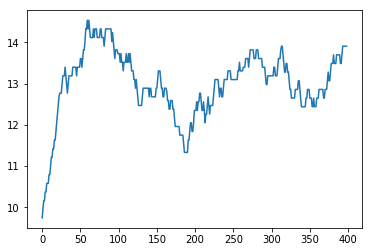

In [9]:
plt.plot(avgRList)

Demostrate one episode

In [18]:
playEpisode = 10
for i in range(playEpisode):
    display.clear_output(wait=True)
    print('Episode ',i+1) 
    time.sleep(0.8)
    state = env.reset()
    done = False
    display.clear_output(wait=True)
    env.render()
    while not done:
            time.sleep(0.3)
            statePre = state
            VconditionStatePre  =np.einsum('ij,ij->i',R[:,statePre,:],P[:,statePre,:])+gamma*np.dot(P[:,statePre,:],V)
            a = np.argmax(VconditionStatePre+np.random.randn(env.action_space.n)*(1/(1.0+episode)))
            state,reward,done,info =  env.step(a)
            display.clear_output(wait=True)
            env.render()
        
    

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


KeyboardInterrupt: 